In [465]:
%load_ext autoreload
from sc.feature_extractor import FeatureExtractor
from sc.deep_feature_extractor import DeepFeatureExtractor
from sc.classifier import Classifier
from sc.signal_manager import SignalMgr
from sc.filter import Filter
from sc.data_reader import DataReader
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
# import xgboost as xgb

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [466]:
skew_train_df = pd.read_csv('/Users/changkong/project/flawSignalDetection/data/train.csv')
skew_test_df = pd.read_csv('/Users/changkong/project/flawSignalDetection/data/test.csv')
skew_train_df = skew_train_df[skew_train_df.sys_result == 7]
skew_test_df = skew_test_df[skew_test_df.sys_result == 7]

In [467]:
skew_train_path = skew_train_df['case_path'].tolist()
skew_test_path = skew_test_df['case_path'].tolist()

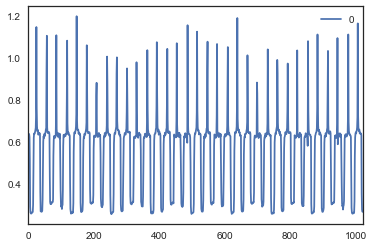

In [468]:
# Assumption1:
# 取出所有信号波谷的斜率，这个的角度比值应该显著小于1，而一等波应该几乎等于1
path = skew_train_path[1]
signals = pd.read_csv(path, skiprows=1, header=None)
signals.plot()

[  25   57   86  119  148  179  209  241  271  302  331  364  393  425
  454  487  516  548  577  610  639  670  699  732  761  793  822  855
  884  916  945  978 1007]
0.6188965
0.2685547
0.30639648
0.63720703


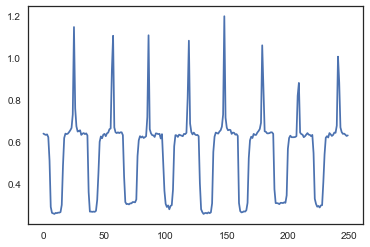

In [469]:
signal_mgr = SignalMgr()
dt, raw_signals = signal_mgr.parse_signals_from_file(path, 1)
print(plt.plot(raw_signals[0:250]))
features = signal_mgr.get_features(path, request_param={'skip_row': [1], 'model_path': ['train']})
print(features['peaks'])
print(raw_signals[17])
print(raw_signals[42])
print(raw_signals[69])
print(raw_signals[94])

In [470]:
features.keys()

dict_keys(['normalized_signals', 'peaks', 'down_peaks', 'negative_peak_num', 'max_down_peak_point', 'up_edges', 'down_edges', 'peaks_num', 'down_peaks_num', 'up_edges_num', 'down_edges_num', 'peak_edge_ratio', 'down_peak_edge_ratio', 'up_edge_height', 'down_edge_height', 'paired_edges', 'paired_edge_height', 'paired_edge_height_diff', 'cyclic_nopeak_seq', 'cyclic_downpeak_seq', 'cyclic_intense_nopeak', 'cyclic_intense_downpeak', 'unit_interviene_length', 'unit_interviene_length_diff', 'inter_diff_mean', 'inter_diff_delta', 'unit_interviene_skewness', 'skewness_mean', 'skewness_delta', 'edge_diff_10', 'edge_diff_20', 'edge_diff_30', 'edge_diff_50', 'paired_edge_width', 'paired_edge_width_diff', 'width_diff_10', 'width_diff_20', 'width_diff_30', 'width_diff_50'])

In [471]:
def end_conditions(x, direction, signals):
    return x >= 0 if direction < 0 else x < len(signals)

def plateau_point(raw_signals, peak_point, direction=-1):
    last_height = raw_signals[peak_point]
    last_i = peak_point
    next_i = peak_point + direction
    while end_conditions(next_i, direction, raw_signals):
        height_diff = abs(raw_signals[next_i] - last_height)
#         print ("last_i:%d, last_height:%f, next_i:%d, next_height:%f" % (last_i, last_height, next_i, raw_signals[next_i]))
        if height_diff < 0.04:
            return next_i
        last_height = raw_signals[next_i]
        last_i = next_i
        next_i = next_i + direction
    return last_i

def get_skew_features(sig_paths):
    bin1 = []
    bin2 = []
    bin3 = []
    bin4 = []
    signal_mgr = SignalMgr()
    for path in sig_paths:
        dt, raw_signals = signal_mgr.parse_signals_from_file(path, 1)
        features = signal_mgr.get_features(path, request_param={'skip_row': [1], 'model_path': ['train']})
        features['peaks']
#         height_diff = []
        WINDOW_SIZE = 2
#         diff_val = []
        bin1_val = 0
        bin2_val = 0
        bin3_val = 0
        bin4_val = 0
        for i in features['peaks']:
            left_height = raw_signals[plateau_point(raw_signals, i - 1, -1)]
        #     print("left part finished")
            right_height = raw_signals[plateau_point(raw_signals, i - 1, 1)]
#             height_diff.append((left_height, right_height))
            height_diff = abs(left_height - right_height)
            if height_diff <= 0.02:
                bin1_val += 1
            elif height_diff <= 0.05:
                bin2_val += 1
            elif height_diff <= 0.1:
                bin3_val += 1
            else:
                bin4_val +=1
        bin1.append(bin1_val)
        bin2.append(bin2_val)
        bin3.append(bin3_val)
        bin4.append(bin4_val)
        #     print (left_height, right_height)
#             diff_val.append(abs(left_height - right_height))
#         mean = np.mean(diff_val)
#         dev = np.std(diff_val)
#         mean_val.append(mean)
#         dev_val.append(dev)
    return bin1, bin2, bin3, bin4

In [472]:
signal_paths = skew_train_df['case_path'].tolist()
bin1, bin2, bin3, bin4 = get_skew_features(signal_paths)

In [473]:
skew_train_df['bin1'] = bin1
skew_train_df['bin2'] = bin2
skew_train_df['bin3'] = bin3
skew_train_df['bin4'] = bin4
# skew_train_df[skew_train_df.sys_result == 9].head(100)

In [474]:
import seaborn as sns
segment_df = skew_train_df[['mean_val', 'dev_val', 'sys_result']]

KeyError: "['mean_val' 'dev_val'] not in index"